# Frowning upon Bias: Exposing the Impact of Race on Emotion Classification

Project mentor: Mark Dredze

Team Members: Kesavan Venkatesh (kvenka10), David Lu (dlu17), Rishi Chandra (rchand18), Liam Wang (wwang136)

https://github.com/Lu-David/frowning-bias

# Outline and Deliverables

### Uncompleted Deliverables
1. "Would like to accomplish #1": Compare the per-race accuracy results of our facial expression model with facial expression models of other popular facial expression models.

We chose to not pursue this objective as we shifted our project towards improving the fairness of our own model instead of comparing fairness to existing models. We started with a baseline model and then explored a variety of techniques to attempt to improve model fairness.


### Completed Deliverables
1. "Must Accomplish #1": Determine the approximate race distribution of at least one popular facial expression dataset. See ["Dataset" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must Accomplish #2": Perform hyperparameter search to tune model with high overall accuracy. See [Results](#Results).
3. "Must Accomplish #3": Train an effective model for facial expression classification using a popular facial expression dataset without stratification by race. See [Results](#Results).
4. "Must Accomplish #4": Compare overall model accuracy on the dataset with the model accuracy on subsets of the dataset broken down by race. See [Results](#Results).
5. "Expect to accomplish #1" Re-train our facial expression model using a stratified train/test split (same distribution in train vs test set) by race and compare overall and per-race model accuracy. See [Results](#Results).
6. "Expect to accomplish #2" Re-train our facial expression model using a stratified train/test split and stratified sampling within groups (same number of each category in each set) by race and compare overall and per-race model accuracy. See [Results](#Results).
7. "Expect to accomplish #3" Perform analysis on model accuracy on the train/test set when broken down by race and facial expression to identify which facial expressions are most likely to be misclassified when considering the distribution of race. See [Results](#Results).
8. "Would like to accomplish #3" Introduce additional dependent variables to compare accuracy across, such as gender or age. See [Results](#Results).

9. "Must complete #1": We discuss our dataset pre-processing [in "Dataset" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
10. "Must complete #2": We discuss training our CNN baseline in [Results](#Results).


### Additional Deliverables
1. We introduced data augmentation to see if varying lighting conditions would make the model more agnostic to demographic characteristics. We discuss this in "Data Augmentation" section below.
2. We trained an "Attribute Aware" model that takes demographic information as an input to see if this would make the model more fair. We discuss this in "Attribute Aware Model" section below.

# Preliminaries

## Problem

Facial recognition systems are used ubiquitously in the real world. Law enforcement bodies use facial recognition algorithms to identify suspects in criminal investigations. Airport security often uses facial recognition algorithms to compare passenger faces in realtime against their passport/documentation photos. Employmers can use these algorithms as part of automated interview software to detect emotions or reactions during an interview.

Despite the serious ethical and practical implications of this problem, prior studies have found signficant bias on facial image-based algorithms. For example, in 2018, Buolamwini & Gebru published their study called "Gender Shades" in which they discovered most large-scale commercial APIs for gender classification had poorer accuracy on minority subgroups (i.e. darker-skinned females, and darker-skinned males). This project really inspired our study because it displays how hidden biases in facial recognition algorithms can create harmful effects when deployed in the real-world.

**Our task is to build upon this prior work to train a convolutional neural network (CNN) to classify images of human facial expression into emotions accurately and fairly across race, gender, and age.**

Our model is similar to the CNNs discussed in class, however we use a variation on CNNs called a ResNet (see Models section).

We chose to look at emotion recognition due to 1) the availability of quality data for this task, 2) how common emotion output is recorded from facial recognition APIs, and 3) the pratical implications of emotion recognition. We take a unique approach to this problem by looking to not just train a classification model, but then also quantify and improve upon classification fairness.

This problem is a multi-class computer vision problem. We studied these kinds of problems in the context of deep learning, and we explored in class how CNNs are popularly used for these problems.


## Dataset

We used the Real-world Affective Faces Database (RAF-DB) dataset. This dataset consisted of roughly 30,000 images of center-cropped human faces. Each face was labeled with an expression (7 classes: angry, disgusted, fearful, happy, sad, surprised, neutral) along with three demographic attributes: race (Caucasian, African American, Asian), age (0-3, 4-19, 20-39, 40-69, 70+), and gender (Male, Female, Unsure (i.e. the gender is not discernable from the image)). Annotations were made by 40 independent human annotators. 

The task we studied in this project was multi-class classification. The target label was the expression label, and the provided input was the image along with the race, age, and gender annotation.
![flowchart.png](figures/flowchart.png)

In our project, we chose to use all three demographic attributes in our fairness analysis. Initially, our project was focused on race; however, as we will later display, our baseline CNN showed interesting biases when intersecting all three of these conditions.


Below, we provide code to setup a local environment. 

In [1]:
# # Run this cell if using google colab
# from google.colab import drive
#
# %cd /content
# ! rm -rf frowning-bias
# ! git clone https://github.com/Lu-David/frowning-bias -b main
# %cd  frowning-bias

In [2]:
from download_data import download_raf

download_raf()

In [3]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 	Gender
# 	0: male		1: female	2: unsure
#    ----------------------------------------------------------------------
# 	Race
# 0: Caucasian		1: African-American		2: Asian
# ----------------------------------------------------------------------
# 	Age (5 ranges)
# 0: 0-3	 1: 4-19		2: 20-39		3: 40-69		4: 70+
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
emotion_lookup = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happiness",
    4: "Sadness",
    5: "Anger",
    6: "Neutral"
}

race_lookup = {
    0: "Caucasian",
    1: "African-American",
    2: "Asian"
}

gender_lookup = {
    0: "Male",
    1: "Female",
    2: "Unsure"
}

age_lookup = {
    0: "0-3",
    1: "4-19",
    2: "20-39",
    3: "40-69",
    4: "70+"
}

# Construct dataframe for train/test data attributes
data_dir = Path("./data")
raf_dir = data_dir / "RAF"
train_dir = raf_dir / "aligned_train"
test_dir = raf_dir / "aligned_test"
annot_dir = raf_dir / "manual"
labels_file = raf_dir / "list_partition_label.txt"
df = pd.read_csv(labels_file, sep=" ", header=None)
df.columns = ["Name", "Emotion"]
df["Path"] = df["Name"].apply(lambda x: os.path.join(str(train_dir), x.replace(".jpg","_aligned.jpg")) if ("train" in x) else os.path.join(str(test_dir), x.replace(".jpg","_aligned.jpg")))
df["Split"] = df["Name"].apply(lambda x: "Train" if ("train" in x) else "Test")
gender = []
race = []
age = []
for i,r in df.iterrows():
    annot_file = os.path.join(str(annot_dir), "{}_manu_attri.txt".format(r["Name"].replace(".jpg","")))
    with open(annot_file, "r") as f:
        lines = f.readlines()
        gender.append(int(lines[5]))
        race.append(int(lines[6]))
        age.append(int(lines[7]))
df["Gender"] = gender
df["Race"] = race
df["Age"] = age
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
df["Emotion"] = df["Emotion"] - 1
df["EmotionLabel"] = df["Emotion"].apply(lambda x: emotion_lookup[x])
df["RaceLabel"] = df["Race"].apply(lambda x: race_lookup[x])
df["GenderLabel"] = df["Gender"].apply(lambda x: gender_lookup[x])
df["AgeLabel"] = df["Age"].apply(lambda x: age_lookup[x])
df_train = df[df["Split"]=="Train"]
df_test = df[df["Split"]=="Test"]
assert len(df) == len(df_train) + len(df_test)

data/RAF/aligned_test/test_1396_aligned.jpg


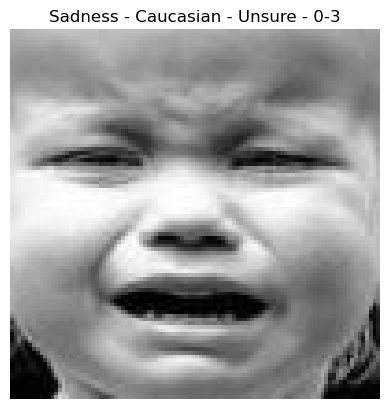

data/RAF/aligned_train/train_08192_aligned.jpg


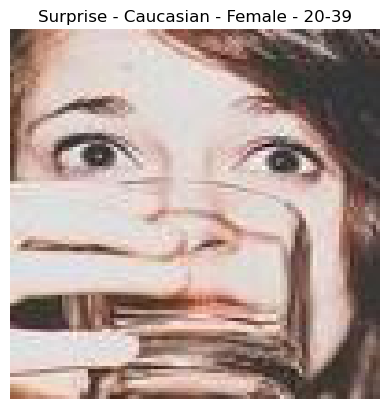

In [5]:
from PIL import Image
from numpy.random import RandomState

random_state = RandomState(1)
samples = df.sample(2, random_state=random_state)
for i in range(len(samples)):
    sample = samples.iloc[i]
    img = Image.open(sample["Path"])
    print(sample["Path"])
    plt.imshow(img)
    plt.title(f"{sample['EmotionLabel']} - {sample['RaceLabel']} - {sample['GenderLabel']} - {sample['AgeLabel']}")
    # hide the axes
    plt.axis('off')
    plt.show()


We can see from these sample images that the RAF-DB dataset is diverse in terms of the lighting conditions, occlusions, head poses, and even post-processing routines applied onto the images.

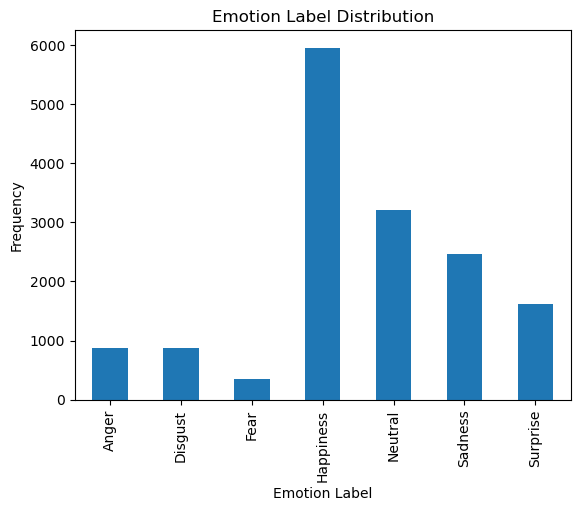

In [6]:
# Distribution of emotion labels
fig, ax = plt.subplots()
ax.set_title("Emotion Label Distribution")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Frequency")
df["EmotionLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

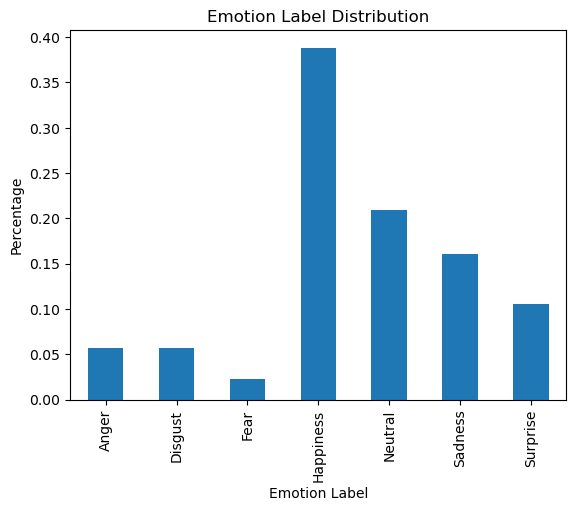

In [7]:
# Distribution of emotion labels
fig, ax = plt.subplots()
ax.set_title("Emotion Label Distribution")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
df["EmotionLabel"].value_counts(normalize=True).sort_index().plot(ax=ax, kind='bar')
plt.show()

In [8]:
df["EmotionLabel"].value_counts()

Happiness    5957
Neutral      3204
Sadness      2460
Surprise     1619
Disgust       877
Anger         867
Fear          355
Name: EmotionLabel, dtype: int64

In [9]:
df["EmotionLabel"].value_counts(normalize=True).mul(100)

Happiness    38.835648
Neutral      20.887933
Sadness      16.037551
Surprise     10.554795
Disgust       5.717452
Anger         5.652259
Fear          2.314362
Name: EmotionLabel, dtype: float64

Notice the dominant emotion labels are happiness, neutral, sadness, and surprise.

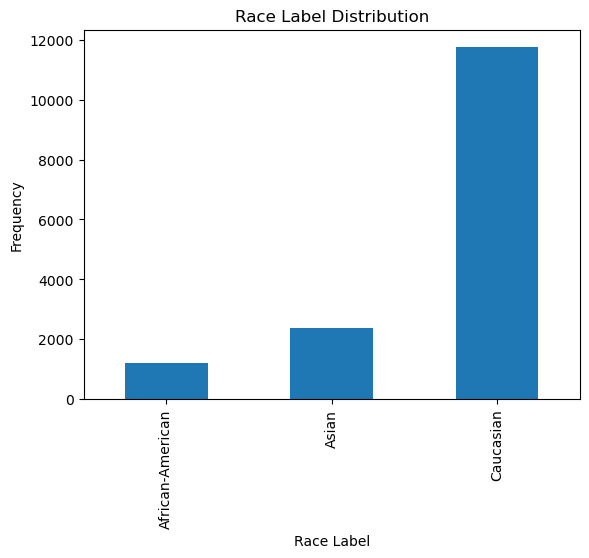

In [10]:
fig, ax = plt.subplots()
ax.set_title("Race Label Distribution")
ax.set_xlabel("Race Label")
ax.set_ylabel("Frequency")
df["RaceLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

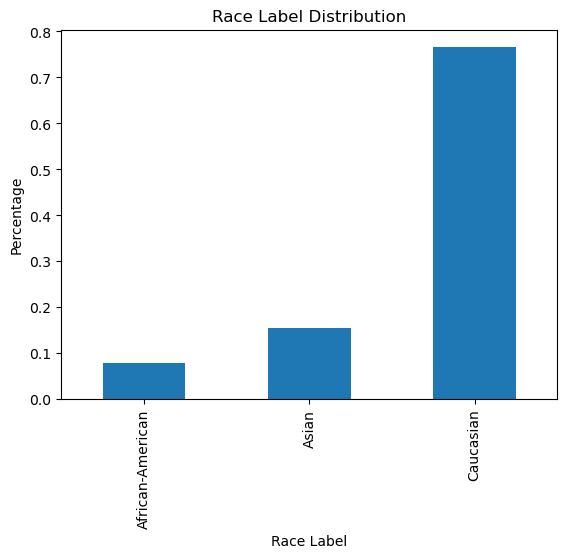

In [11]:
fig, ax = plt.subplots()
ax.set_title("Race Label Distribution")
ax.set_xlabel("Race Label")
ax.set_ylabel("Percentage")
df["RaceLabel"].value_counts(normalize=True).sort_index().plot(ax=ax, kind='bar')
plt.show()

In [12]:
df["RaceLabel"].value_counts()

Caucasian           11742
Asian                2395
African-American     1202
Name: RaceLabel, dtype: int64

In [13]:
df["RaceLabel"].value_counts(normalize=True).mul(100)

Caucasian           76.549971
Asian               15.613795
African-American     7.836234
Name: RaceLabel, dtype: float64

Notice that the dataset is heavily skewed towards Caucasian images.

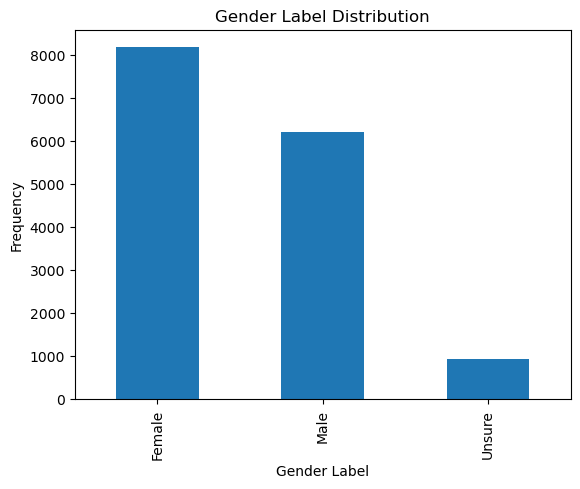

In [14]:
fig, ax = plt.subplots()
ax.set_title("Gender Label Distribution")
ax.set_xlabel("Gender Label")
ax.set_ylabel("Frequency")
df["GenderLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

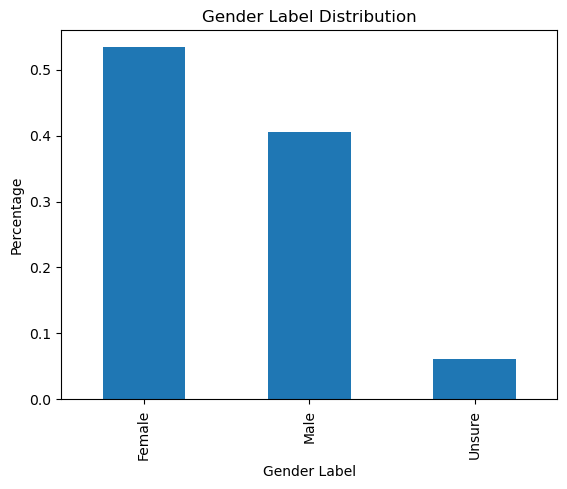

In [15]:
fig, ax = plt.subplots()
ax.set_title("Gender Label Distribution")
ax.set_xlabel("Gender Label")
ax.set_ylabel("Percentage")
df["GenderLabel"].value_counts(normalize=True).sort_index().plot(ax=ax, kind='bar')
plt.show()

In [16]:
df["GenderLabel"].value_counts()

Female    8182
Male      6206
Unsure     951
Name: GenderLabel, dtype: int64

In [17]:
df["GenderLabel"].value_counts(normalize=True).mul(100)

Female    53.341157
Male      40.458961
Unsure     6.199883
Name: GenderLabel, dtype: float64

The dataset is slightly skewed towards female faces, but this not as signficant and somewhat exacerbated by the high frequency of "Unsure" annotations.

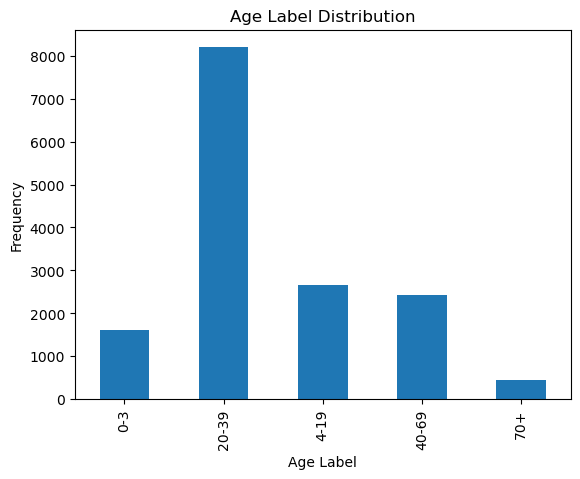

In [18]:
age_label_order = [age_lookup[i] for i in range(5)]
fig, ax = plt.subplots()
ax.set_title("Age Label Distribution")
ax.set_xlabel("Age Label")
ax.set_ylabel("Frequency")
df["AgeLabel"].value_counts().sort_index().plot(ax=ax, kind='bar')
plt.show()

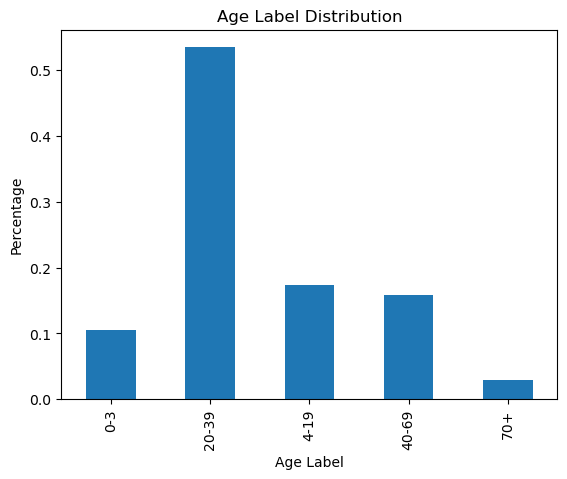

In [19]:
fig, ax = plt.subplots()
ax.set_title("Age Label Distribution")
ax.set_xlabel("Age Label")
ax.set_ylabel("Percentage")
df["AgeLabel"].value_counts(normalize=True).sort_index().plot(ax=ax, kind='bar')
plt.show()

In [20]:
df["AgeLabel"].value_counts()

20-39    8193
4-19     2657
40-69    2422
0-3      1612
70+       455
Name: AgeLabel, dtype: int64

In [21]:
df["AgeLabel"].value_counts(normalize=True).mul(100)

20-39    53.412869
4-19     17.321859
40-69    15.789817
0-3      10.509160
70+       2.966295
Name: AgeLabel, dtype: float64

Most faces were annotated in the 20-39 age strata.

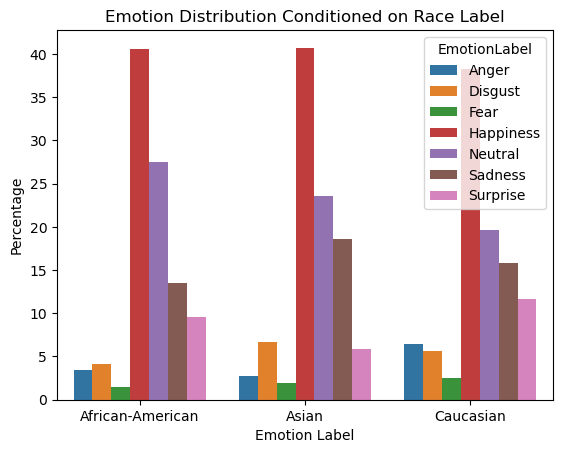

In [22]:
df_emotion_per_race_count = df.groupby(["EmotionLabel", "RaceLabel"]).size().reset_index(name="Count")
df_emotion_per_race_count["Percentage"] = df_emotion_per_race_count.groupby("RaceLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_emotion_per_race_count = df_emotion_per_race_count.sort_values(by=["EmotionLabel", "RaceLabel"])

fig, ax = plt.subplots()
sns.barplot(x="RaceLabel", y="Percentage", hue="EmotionLabel", data=df_emotion_per_race_count, ax=ax)
ax.set_title("Emotion Distribution Conditioned on Race Label")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

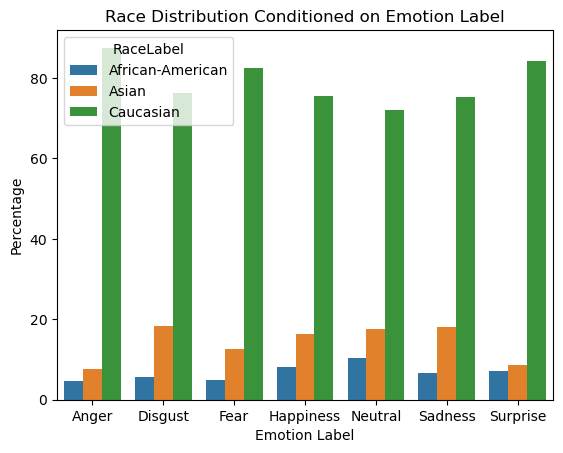

In [23]:
df_race_per_emotion_count = df.groupby(["EmotionLabel", "RaceLabel"]).size().reset_index(name="Count")
df_race_per_emotion_count["Percentage"] = df_race_per_emotion_count.groupby("EmotionLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_race_per_emotion_count = df_race_per_emotion_count.sort_values(by=["EmotionLabel", "RaceLabel"])

fig, ax = plt.subplots()
sns.barplot(x="EmotionLabel", y="Percentage", hue="RaceLabel", data=df_race_per_emotion_count, ax=ax)
ax.set_title("Race Distribution Conditioned on Emotion Label")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

Emotion and race appear fairly independent of each other. That is, the distribution of either variable does not really depend on conditioning on the other.

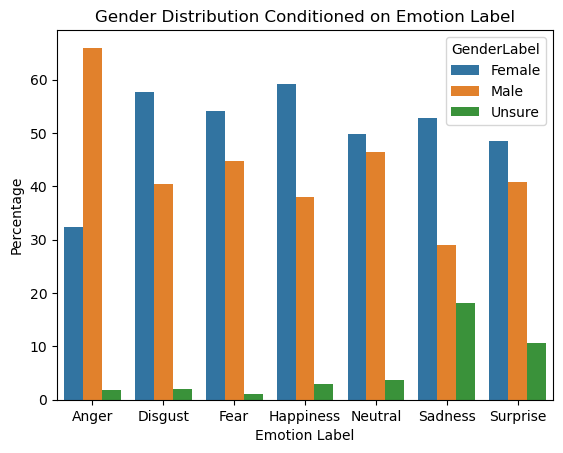

In [24]:
df_gender_per_emotion_count = df.groupby(["EmotionLabel", "GenderLabel"]).size().reset_index(name="Count")
df_gender_per_emotion_count["Percentage"] = df_gender_per_emotion_count.groupby("EmotionLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_gender_per_emotion_count = df_gender_per_emotion_count.sort_values(by=["EmotionLabel", "GenderLabel"])

fig, ax = plt.subplots()
sns.barplot(x="EmotionLabel", y="Percentage", hue="GenderLabel", data=df_gender_per_emotion_count, ax=ax)
ax.set_title("Gender Distribution Conditioned on Emotion Label")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

Notice that the anger emotion class has a signficantly different distribution of genders. While most emotions have more females than males, anger seems to be more frequently male. This might be an implicit bias in characterizing male faces as angry.

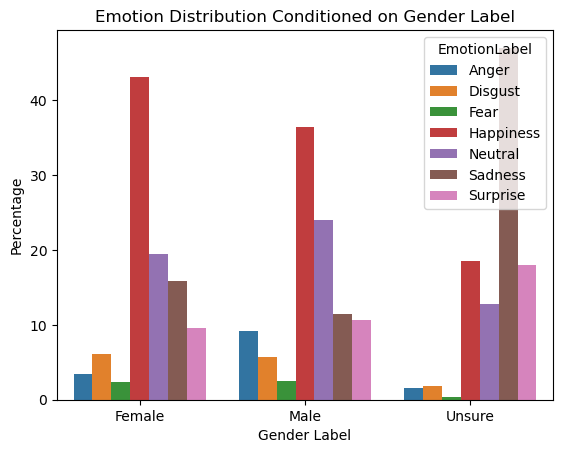

In [25]:
df_emotion_per_gender_count = df.groupby(["GenderLabel", "EmotionLabel"]).size().reset_index(name="Count")
df_emotion_per_gender_count["Percentage"] = df_emotion_per_gender_count.groupby("GenderLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_emotion_per_gender_count = df_emotion_per_gender_count.sort_values(by=["GenderLabel", "EmotionLabel"])

fig, ax = plt.subplots()
sns.barplot(x="GenderLabel", y="Percentage", hue="EmotionLabel", data=df_emotion_per_gender_count, ax=ax)
ax.set_title("Emotion Distribution Conditioned on Gender Label")
ax.set_xlabel("Gender Label")
ax.set_ylabel("Percentage")
plt.show()

Conditioning on gender (male vs female) does not seem to affect the distribution of emotions significantly.

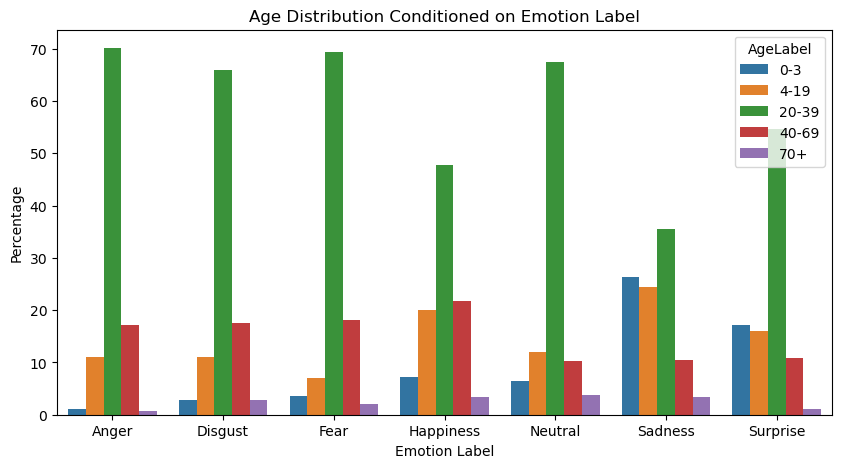

In [26]:
df_age_per_emotion_count = df.groupby(["AgeLabel", "EmotionLabel"]).size().reset_index(name="Count")
df_age_per_emotion_count["Percentage"] = df_age_per_emotion_count.groupby("EmotionLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_age_per_emotion_count = df_age_per_emotion_count.sort_values(by=["AgeLabel", "EmotionLabel"])

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="EmotionLabel", y="Percentage", hue="AgeLabel", data=df_age_per_emotion_count, ax=ax, hue_order=age_label_order)
ax.set_title("Age Distribution Conditioned on Emotion Label")
ax.set_xlabel("Emotion Label")
ax.set_ylabel("Percentage")
plt.show()

Conditioning on emotion generally gives similar age distributions. This does not hold though for sadness, which is more uniform compared to other emotions.

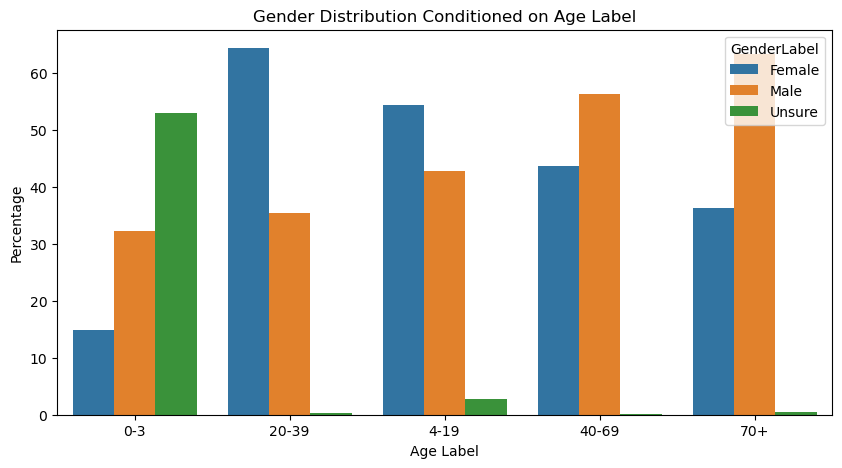

In [27]:
df_gender_per_age_count = df.groupby(["GenderLabel", "AgeLabel"]).size().reset_index(name="Count")
df_gender_per_age_count["Percentage"] = df_gender_per_age_count.groupby("AgeLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_gender_per_age_count = df_gender_per_age_count.sort_values(by=["GenderLabel", "AgeLabel"])

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="AgeLabel", y="Percentage", hue="GenderLabel", data=df_gender_per_age_count, ax=ax)
ax.set_title("Gender Distribution Conditioned on Age Label")
ax.set_xlabel("Age Label")
ax.set_ylabel("Percentage")
plt.show()

Conditioning on age dramatically affects the gender distribution. Notice that ages 0-3, 40-69, and 70+ have more males, but 20-39 and 4-19 have more females.

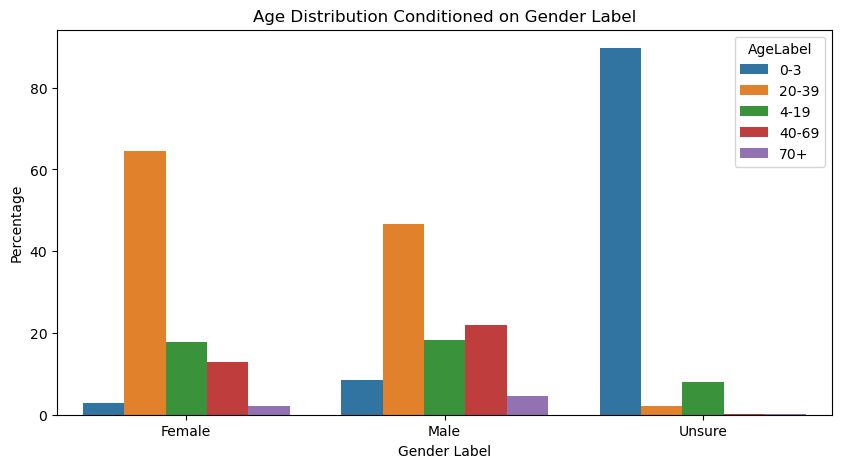

In [28]:
df_age_per_gender_count = df.groupby(["GenderLabel", "AgeLabel"]).size().reset_index(name="Count")
df_age_per_gender_count["Percentage"] = df_age_per_gender_count.groupby("GenderLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_age_per_gender_count = df_age_per_gender_count.sort_values(by=["GenderLabel", "AgeLabel"])

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="GenderLabel", y="Percentage", hue="AgeLabel", data=df_age_per_gender_count, ax=ax)
ax.set_title("Age Distribution Conditioned on Gender Label")
ax.set_xlabel("Gender Label")
ax.set_ylabel("Percentage")
plt.show()

Conditioning on gender (male vs female) leads to similar age distributions.

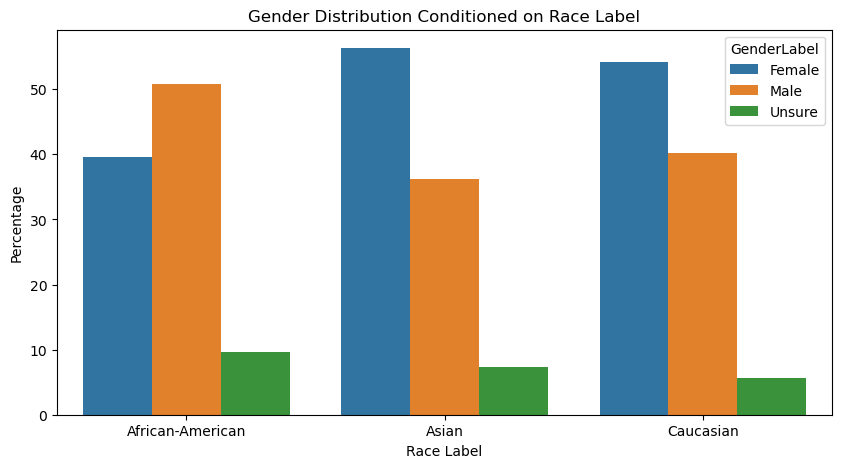

In [29]:
df_gender_per_race_count = df.groupby(["RaceLabel", "GenderLabel"]).size().reset_index(name="Count")
df_gender_per_race_count["Percentage"] = df_gender_per_race_count.groupby("RaceLabel", group_keys=False)["Count"].apply(lambda x: x / x.sum() * 100)
df_gender_per_race_count = df_gender_per_race_count.sort_values(by=["RaceLabel", "GenderLabel"])

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="RaceLabel", y="Percentage", hue="GenderLabel", data=df_gender_per_race_count, ax=ax)
ax.set_title("Gender Distribution Conditioned on Race Label")
ax.set_xlabel("Race Label")
ax.set_ylabel("Percentage")
plt.show()

African-American faces tend to be more Male than Asian and Caucasian faces.

Overall, it is interesting that there are significant differences in emotion label distributions for certain demographics. We discussed several possible causes. For cultural reasons, it might be possible that different age/race/gender groups display emotions differently. It may be possible that the internet source for the images may have had per-demographic skewed distributions of emotions. For instance, if the source was a social media website, people posting images of themselves may be inclined to display different emotions in a way influenced by culture/gender/age norms. It’s also possible that the people responsible for labeling the dataset were consistently biased in the way they understood emotions from different demographics.


### Adjusting Fairness Evaluation based on EDA
Based on our EDA, we chose to adjust how we evaluate fairness. In particular, we chose to first ignore the "Unsure" gender instances in the fairness metrics. This is because the "Unsure" annotation indicated that annotators could not discern the subject's gender from the image. Looking at the data statistics, this mostly applied to images of babies (0-3 age strata). Along a similar vein, we chose to ignore images coming from the 0-3 and 70+ age stratas in our fairness evaluation because these populations do not represent "important" subgroups in our practical applications of emotion recognition. Additionally, the frequency of examples in these groups are much less compared to other age strata.

Below is a summary table for the RAF-DB (original) test split, credit to Xu et al (2020).

![raf_test_xu.png](figures/raf_test_xu.png)

## Pre-processing

As mentioned previously, we chose to use both the image and all three demographic attributes in our analysis. Therefore, our dataset looked like:

$$D = \{\dots, ((x_i, a_i),y_i), \dots\}$$

The target label, emotion expression, was categorical and not balanced. The EDA revealed that the class labels were skewed towards happiness, sadness, and neutral. We handle this during model training by incorporting class weights into the loss function.

We did not have missing data, but we did notice that some "demographic subgroups" were not present in our dataset. See the output below.

In [30]:
for r in range(3):
    for g in range(3):
        for a in range(5):
            count = len(df[(df["Race"]==r) & (df["Gender"]==g) & (df["Age"]==a)])
            print(f"{race_lookup[r]}, {gender_lookup[g]}, {age_lookup[a]}: {count}")

Caucasian, Male, 0-3: 296
Caucasian, Male, 4-19: 732
Caucasian, Male, 20-39: 2288
Caucasian, Male, 40-69: 1179
Caucasian, Male, 70+: 232
Caucasian, Female, 0-3: 172
Caucasian, Female, 4-19: 977
Caucasian, Female, 20-39: 4208
Caucasian, Female, 40-69: 888
Caucasian, Female, 70+: 112
Caucasian, Unsure, 0-3: 584
Caucasian, Unsure, 4-19: 54
Caucasian, Unsure, 20-39: 17
Caucasian, Unsure, 40-69: 1
Caucasian, Unsure, 70+: 2
African-American, Male, 0-3: 178
African-American, Male, 4-19: 173
African-American, Male, 20-39: 168
African-American, Male, 40-69: 80
African-American, Male, 70+: 11
African-American, Female, 0-3: 11
African-American, Female, 4-19: 169
African-American, Female, 20-39: 217
African-American, Female, 40-69: 70
African-American, Female, 70+: 9
African-American, Unsure, 0-3: 108
African-American, Unsure, 4-19: 7
African-American, Unsure, 20-39: 1
African-American, Unsure, 40-69: 0
African-American, Unsure, 70+: 0
Asian, Male, 0-3: 46
Asian, Male, 4-19: 230
Asian, Male, 20-39

We dealt with these missing subgroups by amending our fairness analysis. Specifically, when evaluating fairness
- we ignored images labeled "Unsure" since these were mostly images of babies that annotators apparently struggled to discern the gender of,
- we ignored images labeled "0-3" or "70+" since they were sparsely available in our dataset and did not reflect populations of interest for our project's broader goal/application.

We preprocessed all the data using standard ImageNet transforms. Each image was loaded to be in range [0,1] and normalized using the ImageNet mean and standard deviation. Images are resized from 100x100 to 224x224.

In [31]:
import numpy as np
import torchvision
from torchvision.transforms import ToTensor, Resize, Normalize, RandomInvert

img_size = 224
transform = torchvision.transforms.Compose([ToTensor(), Resize(img_size), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

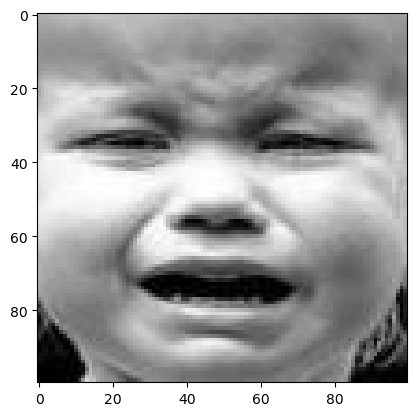

In [32]:
import matplotlib.pyplot as plt
sample_path = "data/RAF/aligned_test/test_1396_aligned.jpg"
sample_image = Image.open(sample_path).convert("RGB")
plt.imshow(sample_image)

We also performed EDA on inverted images, which we use later on (see Method 2).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


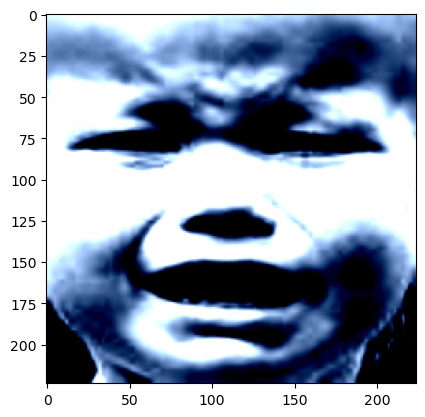

In [33]:
sample_image = transform(sample_image)
sample_image_np = sample_image.numpy().transpose((1,2,0))
plt.imshow(sample_image_np)

We show how this transform affected the mean pixel value per image and per image standard deviation distribution.

In [34]:
pre_transform_means = []
pre_transform_stds = []
post_transform_means = []
post_transform_stds = []
for path in df["Path"]:
    im = Image.open(path).convert("RGB")
    pre_transform_means.append(np.mean(im))
    pre_transform_stds.append(np.std(im))
    post_im = transform(im)
    post_im = post_im.numpy()
    post_transform_means.append(np.mean(post_im))
    post_transform_stds.append(np.std(post_im))

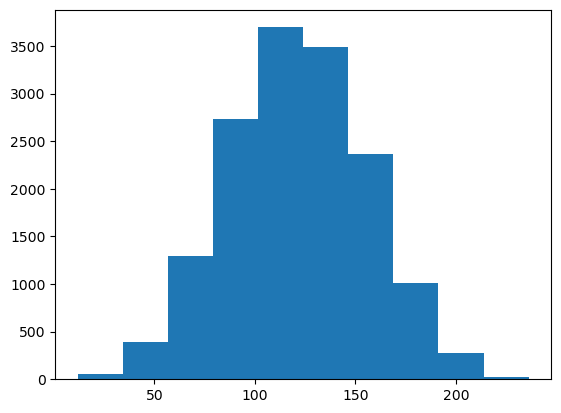

In [35]:
plt.hist(pre_transform_means)
plt.show()

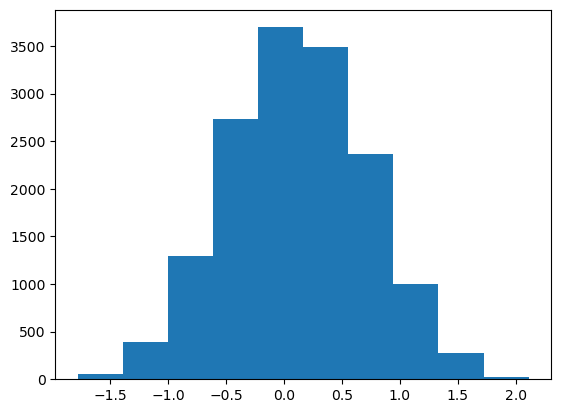

In [36]:
plt.hist(post_transform_means)
plt.show()

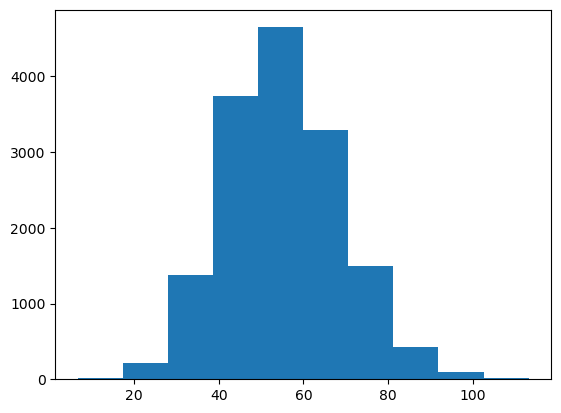

In [37]:
plt.hist(pre_transform_stds)
plt.show()

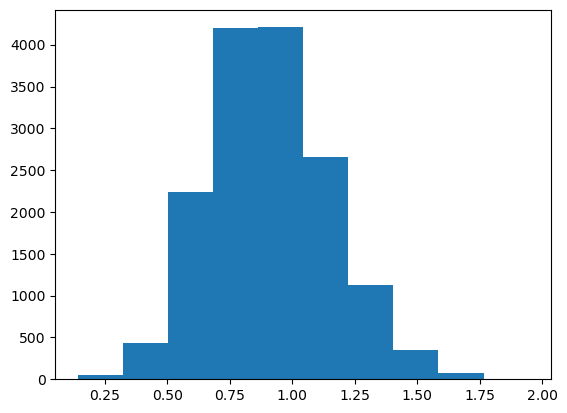

In [38]:
plt.hist(post_transform_stds)
plt.show()

# Models and Evaluation

## Experimental Setup

We evaluated the performance of our trained CNN emotion classifiers on two fronts. We first looked at pure scoring/accuracy metrics:
- accuracy
- AUROC
- F1

These metrics allowed us to sanity-check that our model was learning and make comparisons to performance statistics to state-of-the-art emotion classifiers on RAF-DB. Recall that AUROC is the area under the TPR vs FPR curve (we used a one-vs-all generalization for multiple classes), and F1 score is a metric that captures both the precision and recall of a model's predictions. Using F1 is particularly important for this problem due to the obvious class imbalances present in the dataset.

For fairness, we used equalized opportunity to capture differences in classification performance by demographics. We decided not to use statistical parity because statistical parity only considers the model predictions, not the true labels. Since our exploratory data analysis revealed that different demographic groups had different distributions for emotion labels, it would not be appropriate to use this metric, as we do not necessarily expect that all demographics in this dataset should have the same emotion distributions. We considered using equalized odds, which would provide a more fine-grained picture of whether particular groups were misclassified in consistent ways. However, based on our research into literature on multi-class generalizations of equalized opportunity and odds, we decided to use equalized opportunity as it has a more straightforward meaning in the multi-class case.

Recall for a binary classifier, equalized opportunity requires that

$$P(R=1|Y=1,A=a_1) = P(R=1|Y=1,A=b).$$

We use the generalization presented by Xu et. al:

$$F = \frac{1}{\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=d,x)}} \min_{k} {\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=s_k,x)}}.$$

We select $d$ via

$$d = \text{argmax}_{k} {\sum_{c=1}^{C}{p(\hat{y}=c|y=c,s=s_k,x)}}.$$

Equalized opportunity ensures that the probability of a positive prediction given that the true label is positive is the same across all demographic subgroups. The Xu et. al. equation works by assigning an opportunity score to each demographic group by summing the probability of a positive prediction given that the true label is positive across all classes. The demographic group with the highest opportunity score is then selected as the reference group, "d". The fairness score is then calculated by taking the minimum of the opportunity scores across all demographic groups and dividing by the opportunity score of the reference group. This results in a score ranging from zero to one, where higher is better. A score of one indicates that all demographic groups have the same opportunity score.

We used the cross-entropy loss function with class weights that account for class imbalance. We also modified this loss function in different methods we implemented/tried in order to improve fairness. This will be discussed subsequently in full detail.

We used the provided train/test split for model training and evaluation. For the hyperparameter search, we split our training set further, creating a validation set that we used for early stopping/performance comparisons. The validation split was made at the 80/20 level.

Code for loss functions: see lines 173-184 in train_all.py

Code for train/test split: see split.py

## Baseline

We trained a baseline ResNet18 model to do emotion classification. We chose this model since it was popularly used for classification on RAF-DB and is a robust CNN architecture that is good at avoiding the vanishing gradient problem (due to residual blocks that create "highways" for gradient flow).

Below is the leaderboard for classification accuracy on RAF-DB.

Source: https://paperswithcode.com/sota/facial-expression-recognition-on-raf-db

![image.png](figures/rafdb_leaderboard.png)

The loss function we used to train our baseline model was cross-entropy with inverse weighting per class. Mathematically,
$$L_{\text{batch}} = \frac{1}{B}\sum_{j=1}^{B} l(y_j,\hat{y}_j;w)$$
$$l(y,\hat{y};w) = \sum_{k=1}^{K} = -w_{y_j}y_{j,k}\log\text{Softmax}(\hat{y}_j)$$
$$w_k = \frac{1}{N_k^\text{train}}$$

Let's analyze in detail these equations. The first equation is the per-loss batch: we take the mean cross-entropy loss over the predictions in the batch. We call $l(y,\hat{y};w)$ our per-example cross-entropy loss: this is a function of $y$ and $\hat{y}$ and parameterized by the class weights $w$.

The next equation looks at the per-example cross-entropy loss. $y_j$ is a one-hot vector, so the only contribution in this sum is from the correct class $k'$ of the image. For this closs, we punish low probabilitiy predictions. We build the softmax function into our loss since the ResNet18 architecture we implemented outputs raw class scores (i.e. logits). In order to make it a probability distribution, we must use a Softmax.

Finally, we have to account for class imbalance. To do so, we weight the per-example loss by a weight $w_{k'}$. The weight for a class $k'$ is the inverse of the number of examples of class $k'$ in the training set. By doing so, we accomplish two things:
- if two classes $k_1$ and $k_2$ have similar number of training examples, then the weights for these two classes will be similar.
- if one class $k$ has an over-abundance of training examples, then the weight for this class will be smaller, so the model does not overfit to this class.


## Hyperparameter Search
We performed a hyperparameter search before training the baseline model. Due to constraints on GPU, we limited our hyperparameter search to a small subset of variables that we thought would have an important effect on model performance.

![hparam_grid.png](figures/hparam_grid.png)

For each hyperparameter setting, we trained the model on the training subset (i.e. the training set derived from a further train/val split on the original training set) and compared performance via one-v-all AUROC on the validation set. After selecting our best hyperparameters, we trained all models using these settings on the original training set.

See https://docs.google.com/spreadsheets/d/1Pju7Ey7Nn2OvxeNtkLw6IVwhof0lohpiXrmB8bmw_EY/edit?usp=sharing for the complete results.

| Hyperparameters           | Best Value |
|-------------------------|-------|
| Dropout                 | 0     |
| Learning Rate           | 0.001 |
| Batch Size              | 32    |
| Weight Decay            | 0.001 |
| Early Stopping Patience | 3     |

## Methods
We implemented a variety of methods to attempt to improve model fairness. Recall that we defined fairness using $F$, our generalized equalized opportunity. We also looked at per-demographic accuracies to assess how consistent our model accuracy was across the demographics.

Remember all methods were trained using the original training set, with our searched hyperparameters, and evaluated for baseline performance and fairness on the original test set.

In our project, the key is not the actual implementation of these methods -- most of them are farily straightforward -- but rather finding a technique that could reasonably improve fairness. That latter part was difficult and took a lot of brainstorming and trail/error.

### Method 1: Stratified Sampling
In our first approach, we posited that the model fairness could be improved by making our training dataset consistent across the demographic subgroups. We chose a single attribute (race, age, gender) and resampled our dataset such that each instance of these attributes had an equal number of training examples, $R$. We chose $R$ using either the mean, maximum, or minimum number of examples for an instance of the attribute.
![stratified_sampling.png](figures/stratified_sampling.png)
We implemented this using a PyTorch dataset, see the ```RAFDataset``` class in custom_modules.py.
In all, we trained 9 models (3 attributes, 3 equalizing methods (mean, max, min)) and compared their fairness stats to our baseline.

### Method 2: Preprocessing via Pixel Inversion
Looking again at data-based techniques, we tried to artificially "steer" our CNN away from using demographics in decision making by obscuring the demographic attributes apparent in an image. We attempted to do this by inverting the pixels in the images at both training and test time.
Below is an example of an inversion applied to an input image.
![inversion.png](figures/inversion.png)

### Method 3: Attribute-Aware Model
We implemented an attribute-aware approach as described by Xu et. al. The intuition behind this approach is, instead of implicitly using demographic information that can be inferred from an image, we might be able to improve fairness by just directly giving the model access to demographic attributes. The following figure provides the structure, taken from Xu et al.
![attribute_aware.png](figures/attribute_aware.png)


### Method 4: Affirmative Action Model
In this approach, we tried to make purposeful interventions in our model that overemphasize minority subgroups at train time. We accomplish this via modifications to our loss function. Recalling notation from above, our new "affirmative action" loss function is:
$$L_{\text{batch}} = \frac{1}{B}\sum_{j=1}^{B} l(y,\hat{y};w)\alpha(r_j,g_j,e_j)$$
where $\alpha(r_j,g_j,e_j)$ is a kind of attention factor that we can design. For a proof of concept, we chose a simple structure for $\alpha$, namely
$$\alpha(r_j,g_j,e_j) = 9 \mathbb{I}(r_j=r', g_j=g', e_j=e') + 1.$$
Here, $(r',g',e')$ represents the race, gender, and age triplet for the demographic subgroup we wish to overemphasize at train time. This function will assign our subgroup of interest a weight of $10$ and all other groups a weight of $1$. This scheme punishes a loss function more severely for making mistakes on examples in this "protected subgroup". We can also remember from our discussion in class about backpropogation that the gradients associated with examples in this subgroup will be larger, leading to more dramatic parameter updates.
The natural question then is how do we choose $(r',g',e')$. In this project, we chose these subgroups based on accuracy using our baseline model. We looked at per-demographic accuracy using our baseline model, and we chose the two worst-performing subgroups to boost using affirmative action.

The code for our affirmative action model is available train_all_affraction.py. Note that the underlying model is the same as the baseline, only now we include a "attention" weight in the loss function.

Each of these models were about the same level of difficulty to implement and train, as most of the time was spent waiting for model training to complete, which was relatively constant between models.

We kept all hyperparameters the same as the ones used in the baseline (see Hyperparameter Search section above) in order to keep our models comparable with the baseline model.

## Results

We first show results for our baseline model and then compare this performance (including fairness) against models trained via other approaches.

### Baseline Model
We first plot how the training & validation loss and accuracy changes over training iterations. These "debugging" curves show us that our model has not sufferred from overfitting and can be taken as a good baseline.

Next, we show the performance and fairness results for the baseline model. 

![baseline_stats.png](figures/baseline_stats.png)

#### Plots of Baseline Model Training
See ```./notebooks/training_plots.ipynb``` for plots of baseline model training. We made sure to avoid overfitting by using early stopping by AUC. And based on the accuracy/loss over training, we can be confident that our model is not underfit (for ex: $0.85\%$ is close to the benchmark accuracy).

![baseline_fairness.png](figures/baseline_fairness.png)

What jumps out immediately from these stats is how decently well the baseline model is able to classify emotions and its high equal opportunity by gender. This latter point can be explained by our EDA. Recall that our formulation of fairness does not take into account the unsure gender. If we look at the distribution of gender conditioned by emotion, we see that the Female and Male gender classes have roughly similar frequencies for each emotion. Therefore, we can rationalize why our model is able to make fair predictions by gender.

However, we notice then that the fairness scores for race and age are poor. We look next at the per-demographic accuracies.

![baseline_heatmap.png](figures/baseline_heatmap.png)

From this plot, we see more obvious disparaties in accuracy across demographic subgroups. Two populations that stick out are: 1) Male, African-Americans, 40-69 years old, and 2) Female, Asians, 40-69 years old.

On the other hand, a more suprising result is the strong accuracy for female African-Americans. Given the relative sparsity of African-American images in the dataset, this trend is interesting. To contrast this, notice the accuracy for Caucasian faces is $<90\%$.

This heatmap also offers a nice visualization of fairness. In particular, looking at fairness as a single number, while mathematically rigorous, can hide some of the details (for example: which subgroup in a demographic is most unfair?). Therefore, looking at a heatmap of just accuracy alone can offer a new insight into what the predictions really look like "under the hood".

### Resampling Data
We recorded fairness stats for each of the nine approaches (3 demographic attributes, 3 methods of equalizing). See https://docs.google.com/spreadsheets/d/1thmmfV8aJ9lB_GqUmet-8PoTkYaOso1ABum1zU6rCak/edit?usp=sharing (tab: equalize single attribute).

By fairness metrics, the best performing method was resampling the training data by race using equalizing by mean.

|                      | baseline | Race/Mean |
| -------------------- | -------------------------------- | --------- |
| acc                  | 0.85                             | 0.82      |
| f1                   | 0.84                             | 0.82      |
| auc                  | 0.97                             | 0.96      |
| equal\_opp\_race     | 0.89                             | 0.94      |
| equal\_opp\_gender   | 0.99                             | 0.99      |
| equal\_opp\_age      | 0.88                             | 0.90      |
| acc\_race0           | 0.85                             | 0.81      |
| acc\_race1           | 0.87                             | 0.84      |
| acc\_race2           | 0.83                             | 0.84      |
| acc\_gender0         | 0.83                             | 0.80      |
| acc\_gender1         | 0.85                             | 0.83      |
| acc\_gender2         | 0.89                             | 0.86      |
| acc\_age0            | 0.91                             | 0.88      |
| acc\_age1            | 0.85                             | 0.86      |
| acc\_age2            | 0.84                             | 0.80      |
| acc\_age3            | 0.84                             | 0.82      |
| acc\_age4            | 0.79                             | 0.72      |

We also plot the performance metrics as bars against the baseline.

![resample_stats.png](figures/resample_stats.png)

These results are interesting because they seem to indicate a tradeoff between accuracy and fairness. Resampling the data to equalize race significantly boosted fairness by race, however both overall accuracy and per-race accuracy dropped. In fact, if we look at accuracy within each single attribute, compared to the baseline these accuracies are lower (for all except 4-19 age strata).

This offers an interesting takeaway: while simple data rebalancing might make our predictions more fair, we run the risk of reducing model accuracy across the board. This is a tradeoff that one will have to consider when deploying such algorithms in the "real world".

To drive home this point, here are the evaluation metrics for data resampling to equalize age by mean.

|                      | baseline | Age/Mean |
| -------------------- | -------- | -------- |
| acc                  | 0.85     | 0.81     |
| f1                   | 0.84     | 0.81     |
| auc                  | 0.97     | 0.96     |
| equal\_opp\_race     | 0.89     | 0.84     |
| equal\_opp\_gender   | 0.99     | 0.99     |
| equal\_opp\_age      | 0.88     | 0.91     |
| acc\_race0           | 0.85     | 0.82     |
| acc\_race1           | 0.87     | 0.79     |
| acc\_race2           | 0.83     | 0.79     |
| acc\_gender0         | 0.83     | 0.79     |
| acc\_gender1         | 0.85     | 0.82     |
| acc\_gender2         | 0.89     | 0.87     |
| acc\_age0            | 0.91     | 0.89     |
| acc\_age1            | 0.85     | 0.83     |
| acc\_age2            | 0.84     | 0.79     |
| acc\_age3            | 0.84     | 0.83     |
| acc\_age4            | 0.79     | 0.67     |

Again we see that while equalized opportunity by age increased, per-age accuracies fell, including significant losses for the middle aged folks (age strata 20-39).

### Pixel Inversion
We implemented random pixel inversions during train time (with probability $1/2$). Evaluation metrics are reported below.

|                      | baseline | random invert (p = 0.5) |
| -------------------- | -------- | ----------------------- |
| acc                  | 0.85     | 0.83                    |
| f1                   | 0.84     | 0.83                    |
| auc                  | 0.97     | 0.97                    |
| stat\_parity\_race   | 0.08     | 0.08                    |
| stat\_parity\_gender | 0.10     | 0.10                    |
| stat\_parity\_age    | 0.16     | 0.16                    |
| equal\_opp\_race     | 0.89     | 0.89                    |
| equal\_opp\_gender   | 0.99     | 0.98                    |
| equal\_opp\_age      | 0.88     | 0.82                    |
| acc\_race0           | 0.85     | 0.83                    |
| acc\_race1           | 0.87     | 0.86                    |
| acc\_race2           | 0.83     | 0.82                    |
| acc\_gender0         | 0.83     | 0.81                    |
| acc\_gender1         | 0.85     | 0.84                    |
| acc\_gender2         | 0.89     | 0.88                    |
| acc\_age0            | 0.91     | 0.89                    |
| acc\_age1            | 0.85     | 0.83                    |
| acc\_age2            | 0.84     | 0.82                    |
| acc\_age3            | 0.84     | 0.86                    |
| acc\_age4            | 0.79     | 0.75                    |

![inversion_stats.png](figures/inversion_stats.png)

We see this method simply did not improve fairness. It also resulted in poorer accuracies across the board. Overall, we conclude that inverting the pixels just created a more difficult learning problem, with no significant gains in terms of fairness.


### Attribute Aware Model
We report results for the attribute-aware model.

|                      | baseline | attr aware |
| -------------------- | -------- | ---------- |
| acc                  | 0.85     | 0.86       |
| f1                   | 0.84     | 0.86       |
| auc                  | 0.97     | 0.97       |
| equal\_opp\_race     | 0.89     | 0.87       |
| equal\_opp\_gender   | 0.99     | 0.99       |
| equal\_opp\_age      | 0.88     | 0.86       |
| acc\_race0           | 0.85     | 0.86       |
| acc\_race1           | 0.87     | 0.89       |
| acc\_race2           | 0.83     | 0.85       |
| acc\_gender0         | 0.83     | 0.84       |
| acc\_gender1         | 0.85     | 0.86       |
| acc\_gender2         | 0.89     | 0.92       |
| acc\_age0            | 0.91     | 0.94       |
| acc\_age1            | 0.85     | 0.87       |
| acc\_age2            | 0.84     | 0.84       |
| acc\_age3            | 0.84     | 0.86       |
| acc\_age4            | 0.79     | 0.73       |

In this situation, we see the opposite side of the accuracy-fairness tradeoff. While most per-demographic (and overall) accuracies increase, fairness for race and age drop. To get a handle on these results, we compared them to Xu et. al.

![xu_table4.png](figures/xu_table4.png)


While the baseline model has different fairness, we notice that in both cases fairness by race decreases when no data augmentations were used. On the RAF-DB dataset, it appears that Xu et. al. also had difficulties making consistent gains in fairness using the attribute-aware approach.

This result is quite surprising, because plain intuition would suggest that allowing the model to directly "see" the demographics would make it more fair. Prior literature, for example Guo & Mu 2010 IEEE, would also support this. However, we find that we were not able to backup these conclusions.

### Affirmative Action
We implemented affirmative action on two protected groups: Male, African Americans, 40-69 years old, and Female, Asians, 40-69 years old. We chose these two groups due to worst per-subgroup accuracy with the baseline model.

Results are reported below.

|                      | baseline | Affirmative Action on African-American Male 40-69 yo |
| -------------------- | -------- | ---------------------------------------------------- |
| acc                  | 0.85     | 0.84                                                 |
| f1                   | 0.84     | 0.84                                                 |
| auc                  | 0.97     | 0.97                                                 |
| equal\_opp\_race     | 0.89     | 0.96                                                 |
| equal\_opp\_gender   | 0.99     | 0.99                                                 |
| equal\_opp\_age      | 0.88     | 0.88                                                 |
| acc\_race0           | 0.85     | 0.84                                                 |
| acc\_race1           | 0.87     | 0.85                                                 |
| acc\_race2           | 0.83     | 0.85                                                 |
| acc\_gender0         | 0.83     | 0.81                                                 |
| acc\_gender1         | 0.85     | 0.86                                                 |
| acc\_gender2         | 0.89     | 0.89                                                 |
| acc\_age0            | 0.91     | 0.91                                                 |
| acc\_age1            | 0.85     | 0.86                                                 |
| acc\_age2            | 0.84     | 0.84                                                 |
| acc\_age3            | 0.84     | 0.83                                                 |
| acc\_age4            | 0.79     | 0.74                                                 |

![affraction1_heatmap.png](figures/affraction1_heatmap.png)

![affraction1_stats.png](figures/affraction1_stats.png)

In this first case, affirmative action was able to boost per-subgroup accuracy by 5% compared to the baseline. We notice significant gains in equalized opportunity by race, while maintaining fairly consistent overall accuracy (and F1/AUROC). Looking at accuracy for each single attribute, we see a fairly even change relative to the baseline. In other words, a few attributes (for example, Caucaisan race, Male gender) suffer on accuracy, other groups maintain or slightly increase in accuracy. We conclude that this approach does better on the fairness-accuracy tradeoff than data resampling.

|                      | baseline | Affirmative Action on Asian Female 40-69 yo |
| -------------------- | -------- | ------------------------------------------- |
| acc                  | 0.85     | 0.85                                        |
| f1                   | 0.84     | 0.84                                        |
| auc                  | 0.97     | 0.97                                        |
| equal\_opp\_race     | 0.89     | 0.93                                        |
| equal\_opp\_gender   | 0.99     | 0.99                                        |
| equal\_opp\_age      | 0.88     | 0.92                                        |
| acc\_race0           | 0.85     | 0.85                                        |
| acc\_race1           | 0.87     | 0.88                                        |
| acc\_race2           | 0.83     | 0.83                                        |
| acc\_gender0         | 0.83     | 0.83                                        |
| acc\_gender1         | 0.85     | 0.86                                        |
| acc\_gender2         | 0.89     | 0.88                                        |
| acc\_age0            | 0.91     | 0.91                                        |
| acc\_age1            | 0.85     | 0.86                                        |
| acc\_age2            | 0.84     | 0.83                                        |
| acc\_age3            | 0.84     | 0.86                                        |
| acc\_age4            | 0.79     | 0.75                                        |

![affraction2_heatmap.png](figures/affraction2_heatmap.png)

![affraction2_stats.png](figures/affraction2_stats.png)

Similarly, the second affirmatve-action approach shows a 5% increase in protected subgroup accuracy, significant gains on equalized opportunity, and an overall balanced impact on per-attribute accuracies.

On the other hand, we also notice that affirmative action has some "unwanted" effects. In other words, the impact of over-emphasizing one subgroup in the loss function had a reverberating effect that also impacted the performance on unrelated subgroups. We can see that from the accuracy-by-demographic heatmap. This is a point of interest for potential future projects: can we make our human interventions more controlled so that accuracy only boosts for the demographic attributes of interest?

### Overall Results

For each of our models, we did not observe a significant difference in the amount of overfitting compared to our baseline model, thanks to the early stopping functionality in our code. 

We expect these models to perform similarly on other facial recognition datasets because we feel that RAF-DB is a good example of a decent quality dataset with enough diversity in demographics, lighting conditions, and head poses.

We propose two key takeaways:
- There appears to be a tradeoff between fairness and overall accuracy. (no free lunch!)
- Our affirmative action method is the best at improving fairness while minimizing the impact on accuracy.

# Discussion

## What you've learned

**What concepts from lecture/breakout were most relevant to your project? How so?**

Our project idea was inspired by the quality of service and resource allocation discussion during the third fairness lecture, specifically regarding potential racial bias in facial recognition machine learning algorithms. We wanted to dig deeper and explore whether tweaks to a model and/or data augmentation would influence the fairness metrics that we discussed in class such as equal opportunity, equal odds, and statistical parity. We also used other more standard metrics that we learned in lectures such as the F1 score and AUC. These metrics allowed us to assess the quality of the model. Additionally, the lectures on CNNs were relevant as we chose to use ResNet, a type of CNN, to build the facial recognition model. Our understanding of how CNNs are structured was useful as we wrote code to pre-process the images into the appropriate format for the ResNet model. Finally, the fairness lecture material on sources of bias in datasets was important to our project as we had to consider types of bias that may have been introduced when the RAF-DB dataset was collected and labeled.

**What aspects of your project did you find most surprising?**

We were surprised that most of our ideas to improve model fairness, such as stratifying by demographics or demographic-aware models, seemed to have no effect or even cause fairness metrics to worsen. This included more complicated and previously tested model schemes, see our attempt to replicate a model from Xu 2020. From our experience, it seemed like training on a big dataset with skewed demographics resulted in fairer models than training on a small dataset with balanced demographics. This highlights the importance of focusing on fairness between quality and quantity of data from different demographics when collecting data for a machine learning dataset, and suggests that attempts to artificially remedy poor data will often be less effective.

**What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?**

One important takeaway from this project was the importance of performing thorough exploratory data analysis and to particularly look out for undesirable patterns caused by the way the data was collected. For instance, our dataset had an "unknown" gender label, which we found didn't mean nonbinary, and instead was mostly infants. Since the face images were sourced from internet photos, the human annotators often didn’t know the gender of the individual in the image. We also found that there were also certain demographics, such as 70+ individuals, which were seriously underrepresented in the dataset, which led us to exclude these demographics from our fairness metrics as we wouldn’t be able to get a statistically significant idea of the actual fairness of our model on these populations. Another related takeaway is the importance of considering sources of bias in the data collection process. Since the labels in the dataset were created by human annotators, who all have implicit biases, it is entirely possible that the dataset contains demographic and emotion labels that are systematically wrong, due to personal or cultural biases. This led us to discuss whether there were any procedures we would do differently if we were to collect our own emotion dataset in future in order to minimize bias. One idea we had was to have individuals self-identify their demographic information and emotion, as the individuals in the photos would probably have the best judgment for this information. However, this method would be much more time-consuming and costly. Overall, we think that these lessons will transfer well to other datasets and models, especially ones that deal with human classification that may involve demographic information, as we specifically designed our methods to be agnostic of the particular architecture of the machine learning model.

**What was the most helpful feedback you received during your presentation? Why?**

One helpful observation was from Ruilin Sun's group about our “affirmative action” models. They pointed out that in our model that emphasizes  Male, 40-69 yo, African-Americans, the accuracy increased by 5% compared to the baseline. But with our model that focuses on Female, 40-69 yo, Asians, the accuracy of Male, 40-69 yo, African American increased by 10%, which is even more than when the model focused on this directly. They asked us to elaborate on our ideas for why this unexpected result may have happened. One potential explanation would be that when the model was forced to focus on a more diverse range of faces, it happened to learn more generalizable features when focusing on this other demographic, leading to an all-around increase in accuracy. We believe that this result shows that there is not a simple relationship between the demographic subgroups we choose to overemphasize and the demographic subgroups that benefit from this intervention. It also suggests that a model that could iteratively learn to tune these “affirmative action” weights as part of the training loop would be more effective than a model that simply chooses the weights based on the accuracies of the baseline model in a single step.

**If you had two more weeks to work on this project, what would you do next? Why?**

Our idea for future development of this project would be to develop a model that can iteratively learn to tune the “affirmative action” weights as part of the training loop. Perhaps, after each epoch, it could calculate the training accuracies and fairness metrics for each demographic and update relative weightings of the examples based on the accuracies of the subgroups. In order to do this, we would need to decide on an acceptable trade-off between overall accuracy and fairness, which is an interesting ethical question that likely depends on the intended real-world application for a particular model.


# References

[1] F. Ramzan et al., “A Deep Learning Approach for Automated Diagnosis and Multi-Class Classification of Alzheimer’s Disease Stages Using Resting-State fMRI and Residual Neural Networks,” J Med Syst, vol. 44, no. 2, p. 37, Dec. 2019, doi: 10.1007/s10916-019-1475-2.

[2] A. Paszke et al., “PyTorch: An Imperative Style, High-Performance Deep Learning Library,” in Advances in Neural Information Processing Systems 32, Curran Associates, Inc., 2019, pp. 8024–8035. [Online]. Available: http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf

[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition.” arXiv, Dec. 10, 2015. Accessed: Dec. 08, 2022. [Online]. Available: http://arxiv.org/abs/1512.03385

[4] S. Li, W. Deng, and J. Du, “Reliable Crowdsourcing and Deep Locality-Preserving Learning for Expression Recognition in the Wild,” in 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Honolulu, HI, Jul. 2017, pp. 2584–2593. doi: 10.1109/CVPR.2017.277.

[5] J. Buolamwini and T. Gebru, “Gender Shades: Intersectional Accuracy Disparities in Commercial Gender Classification,” in Proceedings of the 1st Conference on Fairness, Accountability and Transparency, Jan. 2018, pp. 77–91. Accessed: Dec. 08, 2022. [Online]. Available: https://proceedings.mlr.press/v81/buolamwini18a.html

[6] T. Xu, J. White, S. Kalkan, and H. Gunes, “Investigating Bias and Fairness in Facial Expression Recognition.” arXiv, Aug. 21, 2020. Accessed: Dec. 08, 2022. [Online]. Available: http://arxiv.org/abs/2007.10075